In [18]:
#Librerías a utilizar
import pandas as pd
import numpy as np

#Graficas 
import graphing
import missingno as ms
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.tree import plot_tree # Función para visualizar el árbol

#Selecionar caracteristicas 
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

#Modelos 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import layers


#Metricas
from sklearn.metrics import balanced_accuracy_score, roc_curve, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

#Transformaciones, separaciones  e imputaciones  
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import make_column_transformer

#Funciones
from Funciones import matrix_confusion, fit_and_test_model, CurvaROC, FeatureBest,matrix_confusion_Xgboost


In [19]:
# Lee el archivo de texto prueba que contiene los datos usando pandas
Df_Spaces_test=pd.read_csv('test.csv')

# Lee el archivo de texto entrebamiento que contiene los datos usando pandas
Df_Spaces_train=pd.read_csv('train.csv')

#Descomponer columna para tener una mayor interpretación de los datos
#Column Total
def agregar_Caracteristicas(df):
    #Column PassengerId
    df[['Group','Num_Group']]=df.PassengerId.str.split('_', expand=True)
    #Columna Cabin
    df[['Desk','Num','Side']]=df.Cabin.str.split('/', expand=True)

    #Eliminar las columnas Cabin y Name
    df.drop(['Cabin','Name'], axis=1, inplace=True)

    
    #Cambiar el tipo de columnas Número de grupo
    df['Num_Group'] = df['Num_Group'].astype('int64')
    
    


agregar_Caracteristicas(Df_Spaces_train)
agregar_Caracteristicas(Df_Spaces_test)

In [20]:
#Column Cabin
def Cambiar_Nulos_HomePlanet(df):
    """ Cambiar los nulos por un valores más probables"""
    
    df.loc[(((df['Desk']=='A') | (df['Desk']=='B') | (df['Desk']=='C') | (df['Desk']=='T')) & (df['HomePlanet'].isnull())), 'HomePlanet']='Europa'
    df.loc[((df['Desk']=='G') & (df['HomePlanet'].isnull())), 'HomePlanet']='Earth'
    df.loc[((df['Desk']=='T') & (df['CryoSleep'].isnull())), 'CryoSleep']=False
    df.loc[(((df['Num_Group']=='7') | (df['Num_Group']=='8')) & (df['VIP'].isnull())), 'VIP']='False'
    df.loc[(((df['Num_Group']=='8')) & (df['HomePlanet'].isnull())), 'HomePlanet']='Earth'
    df['CryoSleep'] = df['CryoSleep'].astype('object')

    

Cambiar_Nulos_HomePlanet(Df_Spaces_train)
Cambiar_Nulos_HomePlanet(Df_Spaces_test)

In [21]:
def LimpiezaVariables(df):
    """ Esta funcion reemplaza los valores faltantes por el criterio más adecuado """
    
    #Remplar los valores ceros en edad por Valores perdidos
    df.Age.replace(0,np.nan, inplace=True)
    #Columnas númericas 
     #Llenar los valores perdidos de la edad utilizando la mediana por sexo
     
    # Se Reemplazan los valores faltantes en las columnas númericas 
    df['Age']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['Age']])
    df['RoomService']=SimpleImputer(missing_values=np.nan,strategy='median').fit_transform(df[['RoomService']])
    df['FoodCourt']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['FoodCourt']])
    df['ShoppingMall']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['ShoppingMall']])
    df['VRDeck']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['VRDeck']])
    df['Spa']=SimpleImputer(missing_values=np.nan,strategy='mean').fit_transform(df[['Spa']])

    # Columnas Categorícas 
    df["Desk"]=df["Desk"].replace("np.nan",np.nan)

    df['HomePlanet']=df.groupby('Num_Group', group_keys=False)['HomePlanet'].apply(lambda x: x.fillna(x.mode()[0]))
    df['CryoSleep']=df.groupby('Num_Group', group_keys=False)['CryoSleep'].apply(lambda x: x.fillna(x.mode()[0]))
    df['VIP']=SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df[['VIP']])
    df['Destination']=df.groupby('Num_Group', group_keys=False)['Destination'].apply(lambda x: x.fillna(x.mode()[0]))
    df['Side']=df.groupby('CryoSleep', group_keys=False)['Side'].apply(lambda x: x.fillna(x.mode()[0]))
    df['Desk']=df.groupby('Num_Group', group_keys=False)['Desk'].apply(lambda x: x.fillna(x.mode()[0]))
    df['Num']=SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df[['Num']])
    
    df['Num']=df['Num'].astype('int64')
LimpiezaVariables(Df_Spaces_train)
LimpiezaVariables(Df_Spaces_test)

In [22]:
def Ifeatures(df):
    df['Total']=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    df['totalpasajeros*desk']=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].product(axis=1)
    # Total passengers by Deck
    
Ifeatures(Df_Spaces_train)
Ifeatures(Df_Spaces_test)


In [23]:
#Imputación de la columna objetivo a numeros 
label_encoder=LabelEncoder()
Df_Spaces_train['Transported']=label_encoder.fit_transform(Df_Spaces_train['Transported'])

In [24]:
Etiquetas=[False, True]
X = Df_Spaces_train.copy() # Se hace una copia al dataset
y=X.Transported
X.drop(['PassengerId','Group','Transported'], axis=1, inplace=True)


In [25]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=object)),
     (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=bool))
)

X= preprocessor.fit_transform(X)
columnas_data=pd.DataFrame(X)
X_train, X_valid, y_train, y_valid=train_test_split(X,y, test_size=0.3, train_size=0.7, random_state=0)

<AxesSubplot: >

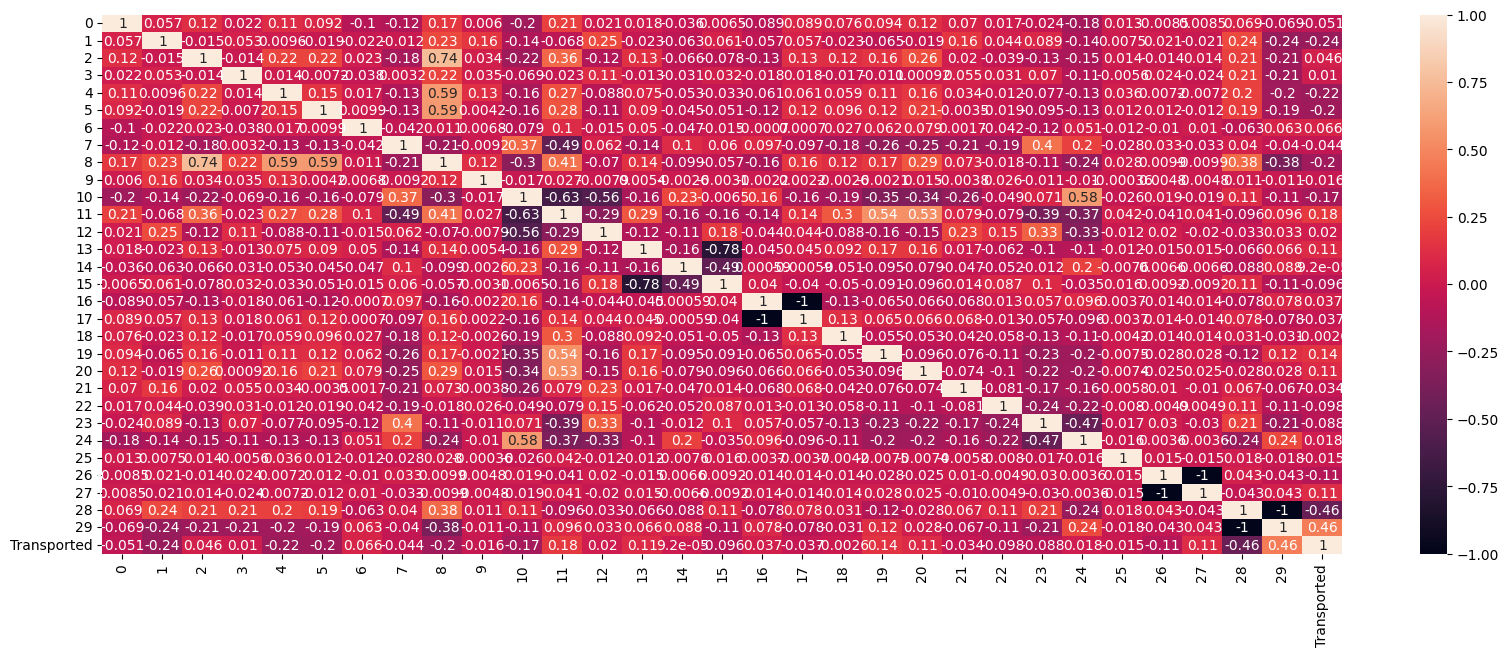

In [26]:
df=pd.concat([columnas_data,y], axis=1)
fig=plt.subplots(1, figsize=(20,7))
df=df.corr()
sns.heatmap(df, annot=True)

In [27]:
columnas=[1,2,3,4,5,6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,26,28]

In [28]:
# Set data types for float features
X_train = X_train[:,[1,2,3,4,5,6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,26,28]].astype('float64')
X_valid= X_valid[:,[1,2,3,4,5,6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,26,28]].astype('float64')

# Set data types for categorical labels
y_train = utils.to_categorical(y_train)
y_valid = utils.to_categorical(y_valid)
print('Ready...')

Ready...


In [29]:
  # Define a classifier network
hl = 43 # Number of hidden layer nodes

model = Sequential()
model.add(Dense(hl, input_dim=len(columnas), activation='relu'))
model.add(Dense(hl, input_dim=hl, activation='relu'))
model.add(Dense(len(Etiquetas), input_dim=hl, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1075      
                                                                 
 dense_4 (Dense)             (None, 43)                1892      
                                                                 
 dense_5 (Dense)             (None, 2)                 88        
                                                                 
Total params: 3,055
Trainable params: 3,055
Non-trainable params: 0
_________________________________________________________________


In [30]:
#hyper-parameters for optimizer
learning_rate =0.006
opt = optimizers.Adam(learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

early_stopping =callbacks.EarlyStopping(
        min_delta=0.0001, # minimium amount of change to count as an improvement
        patience=10, # how many epochs to wait before stopping
        restore_best_weights=True)

    # Train the model over 50 epochs using 10-observation batches and using the test holdout dataset for validation
num_epochs = 40
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=74, validation_data=(X_valid, y_valid), callbacks=[early_stopping],
        verbose=0)

Minimum Validation Loss: 0.3987


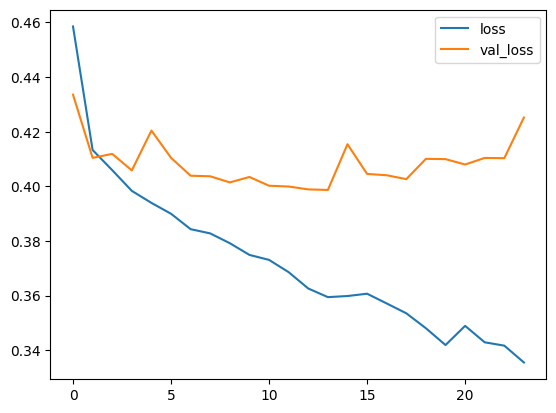

In [31]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [32]:
class_probabilities = model.predict(X_valid)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_valid, axis=1)

# Plot the confusion matrix
print(balanced_accuracy_score(true_labels, predictions))
confusion_matrix(true_labels, predictions)



82/82 [==============================] - 0s 868us/step
0.8009800548689585


array([[1015,  288],
       [ 231, 1074]], dtype=int64)

In [33]:
# #Use the model to predict the class
# Df_Spaces_test.drop(['Group'], axis=1, inplace=True)
# X=Df_Spaces_test.set_index('PassengerId')


In [36]:
# X_test=preprocessor.fit_transform(X)
# X_test_data=pd.DataFrame(X_test.astype('float64'))
# class_probabilities=model.predict(X_test)
# predictions = np.argmax(class_probabilities, axis=1)
# preds_test=[Etiquetas[predictions[i]] for i in range(0, (Df_Spaces_test.shape[0]))]
# # Save test predictions to file
# # output = pd.DataFrame({'PassengerId': X.index,
# #                        'Transported': preds_test})
# # output.to_csv('submission.csv', index=False)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_3/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1919, in _run_once
      handle._run()
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_13020\1913187315.py", line 3, in <module>
      class_probabilities=model.predict(X_test)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/dense_3/Relu'
Matrix size-incompatible: In[0]: [32,30], In[1]: [24,43]
	 [[{{node sequential_1/dense_3/Relu}}]] [Op:__inference_predict_function_28091]